In [1]:
import warnings
warnings.filterwarnings("ignore")

from src.acquire import get_zillow_data
from src.prepare import wrangle_zillow, geo_df, split_data

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

lucario = ['#6EA4BB', '#C04C4B', '#464646', '#E7E7E6', '#F0DBA5']
sns.set_palette(sns.color_palette(lucario))

import geopandas as gpd
from shapely.geometry import Point, Polygon

from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import eli5

[Modeling](#2)

In [2]:
#df = get_zillow_data()
#df.to_csv("data/sfr_2017.csv")

df = pd.read_csv("data/sfr_2017.csv", index_col=0)
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(df, k=2.8) #k specifies outlier clipping
X_train.info()

X_train, X_test, X_val, y_train, y_test, y_val
(17663, 18) (3786, 18) (3785, 18) (17663,) (3786,) (3785,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17663 entries, 18377 to 25982
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcelid                17663 non-null  int64  
 1   transactiondate         17663 non-null  object 
 2   latitude                17663 non-null  float64
 3   longitude               17663 non-null  float64
 4   bedroomcnt              17663 non-null  int64  
 5   roomcnt                 17663 non-null  int64  
 6   bathroomcnt             17663 non-null  int64  
 7   finishedsqft            17663 non-null  int64  
 8   lotsqft                 17663 non-null  int64  
 9   year                    17663 non-null  int64  
 10  taxamount               17663 non-null  int64  
 11  taxrate                 17663 non-null  float64
 12  fips                    17663 non-

In [10]:
X_train.head()

,parcelid,transactiondate,latitude,longitude,bedroomcnt,roomcnt,bathroomcnt,finishedsqft,lotsqft,year,taxamount,taxrate,fips,structuretaxvalue,landtaxvalue,livingarearatio,buildinglandvalueratio,county
18377,11921611,2017-07-18,34.13,-118.09,4,12,6,4467,18131,1989,12575,0.01,6037,198640,794587,0.25,0.25,Los Angeles
14188,11306776,2017-06-29,34.70,-118.19,4,9,3,3152,7149,2004,3763,0.02,6037,188873,44562,0.44,4.24,Los Angeles
18252,12389465,2017-07-18,33.99,-118.09,3,6,1,1018,5287,1952,4850,0.01,6037,56000,327000,0.19,0.17,Los Angeles
25947,13884499,2017-08-24,33.80,-117.85,3,5,1,984,5950,1954,855,0.02,6059,21789,27546,0.17,0.79,Orange
18398,17200393,2017-07-18,34.27,-118.87,4,7,3,2060,6825,1987,4746,0.01,6111,253150,168761,0.30,1.50,Ventura


In [3]:
X_train.county.value_counts()

Los Angeles    11070
Orange          4980
Ventura         1613
Name: county, dtype: int64

In [3]:
#https://gisdata-scag.opendata.arcgis.com/datasets/county-boundaries-scag-region/explore?filters=eyJBQ1JFUyI6WzY4Ny40OTYwMjEyOCwyNzUwNTIyLjMyXX0%3D&location=34.131659%2C-116.867850%2C7.00
file = 'data/County_Boundaries/County_Boundaries_%E2%80%93_SCAG_Region.shp'
geo_df, map_ = geo_df(X_train, y_train, file)

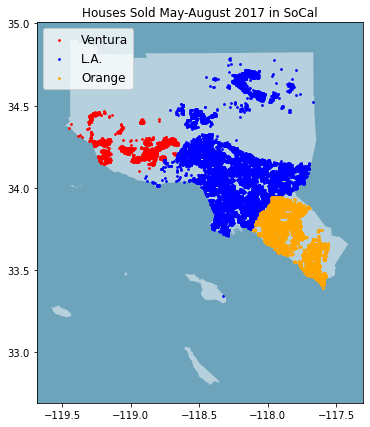

In [7]:
f, ax = plt.subplots(figsize=(11,7))
ax.set_facecolor(lucario[0])
map_.plot(ax=ax, alpha=.5, color='white')

geo_df[geo_df.fips==6111].plot(ax=ax, markersize=3, color='red', label="Ventura")
geo_df[geo_df.fips==6037].plot(ax=ax, markersize=3, color='blue', label="L.A.")
geo_df[geo_df.fips==6059].plot(ax=ax, markersize=3, color='orange', label="Orange")

plt.title("Houses Sold May-August 2017 in SoCal")
plt.legend(prop={'size':12});

<img src="img/socal.png" width=300px>

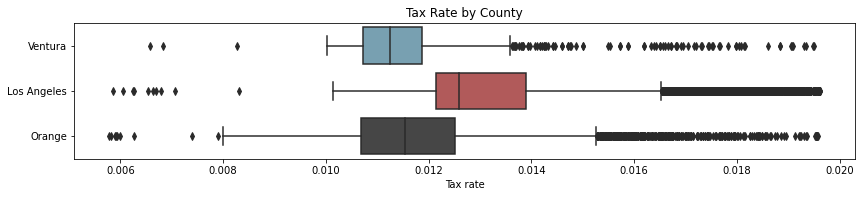

In [87]:
counties = ["Ventura", "Los Angeles", "Orange"]

plt.figure(figsize=(14, 2.5))
sns.boxplot(data=X_train, y='county', x='taxrate', order=counties)
plt.ylabel("")
plt.xlabel("Tax rate")
plt.title("Tax Rate by County")
plt.show()

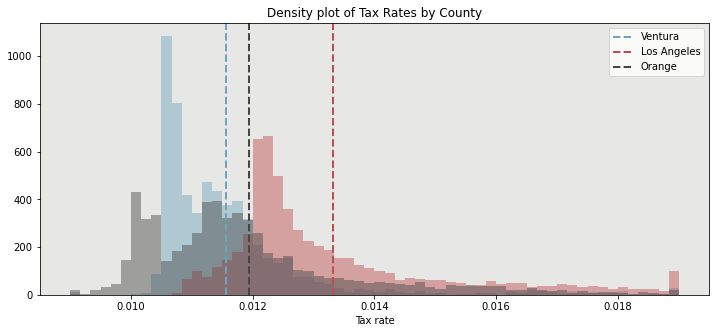

In [64]:
f, ax = plt.subplots(figsize=(12,5))
for i, county in enumerate(counties):
    ax.set_facecolor(lucario[3])
    plt.title("Density plot of Tax Rates by County")
    plt.xlabel("Tax rate")
    #so bins are the same width
    clipped = X_train.taxrate[X_train.county==county].clip(.009, .019)
    plt.axvline(clipped.mean(), color=lucario[i], linestyle='dashed', linewidth=2)
    #plt.text(1, 700, 'Mean: ${:.0f}'.format(clipped.mean()))
    clipped.hist(bins=60, alpha=.45, density=True)
    plt.grid(False)
plt.legend(counties);

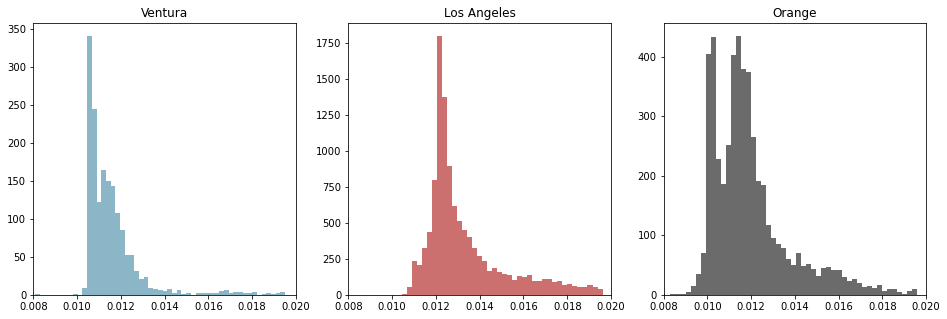

In [56]:
counties = ["Ventura", "Los Angeles", "Orange"]
plt.figure(figsize=(16,5))
for i, county in enumerate(counties):
    plot_number = i + 1 
    plt.subplot(1, len(counties), plot_number)
    plt.title(county)
    plt.xlim(.008, .02)
    X_train.taxrate[X_train.county==county].hist(bins=60, alpha=.8, color=lucario[i])
    plt.grid(False)

<a id='2'></a>
## Modeling

In [3]:
y_pred = np.zeros((len(y_val),)) + y_train.mean()
print("Evaluating the Mean Model:")
print(f"  RMSE: {int(mean_squared_error(y_val, y_pred, squared=False))}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),4)}")

Evaluating the Mean Model:
  RMSE: 318186
  R^2: -0.0


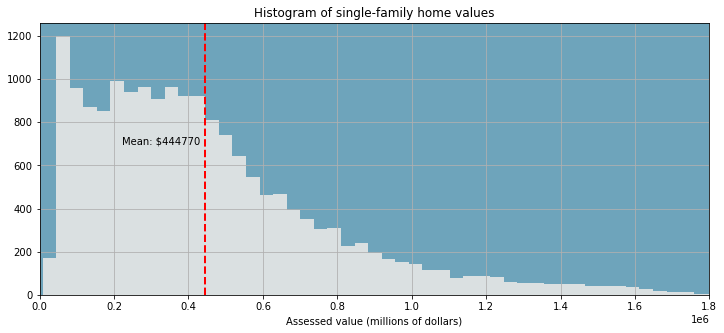

In [53]:
f, ax = plt.subplots(figsize=(12,5))
ax.set_facecolor(lucario[0])
plt.title("Histogram of single-family home values")
plt.xlabel("Assessed value (millions of dollars)")
plt.xlim(0, 1.8e6)
plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=2)
plt.text(2.2e5, 700, 'Mean: ${:.0f}'.format(y_train.mean()))
y_train.hist(bins=50, alpha=.9, color=lucario[3]);

In [10]:
xvars = ['bedroomcnt', 'sqft']

reg = LinearRegression().fit(X_train[xvars], y_train)
y_pred = reg.predict(X_val[xvars])

print("Evaluating the MVP Model:")
print(f"  RMSE: {int(mean_squared_error(y_val, y_pred, squared=False))}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),4)}")

Evaluating the MVP Model:
  RMSE: 262998
  R^2: 0.3168


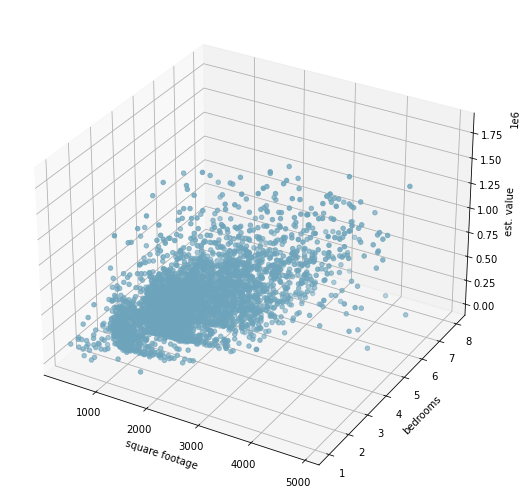

In [20]:
#%matplotlib widget

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection = '3d')

y = X_val['bedroomcnt']
x = X_val['sqft']
z = y_val
ax.set_ylabel("bedrooms")
ax.set_xlabel("square footage")
ax.set_zlabel("est. value")
 
# plot the plane
#ax.plot_surface(x, y, z, alpha=0.5)
ax.scatter(x, y, z)

plt.show()

In [9]:
xvars = ['latitude', 'longitude', 'bedroomcnt', 'roomcnt', 'bathroomcnt',
         'finishedsqft', 'lotsqft', 'year', 'livingarearatio']

reg = make_pipeline(StandardScaler(), LinearRegression())

reg.fit(X_train[xvars], y_train)
y_pred = reg.predict(X_val[xvars])

print("Evaluating the Advanced Model:")
print(f"  RMSE: {int(mean_squared_error(y_val, y_pred, squared=False))}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),4)}")

Evaluating the Advanced Model:
  RMSE: 251709
  R^2: 0.3122
